## This notebook is for decoder based analysis of the game data for preparing the pilot experiment

In [1]:
# import libraries
import sys
import numpy
sys.path.insert(0,'/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/PilotExperiment/BrainMachineInterfaces_pilotExperiment')
from DataAnalysis.dataAnalysisClasses import *
import matplotlib.pyplot as plt

def plotComparison(var1,var2,plotFrom,plotTo,label = "",var1Label = "true",var2label = "actual"):
    plt.plot(var1[plotFrom:plotTo,0],var1[plotFrom:plotTo,1],label = var1Label +label,color = 'tab:blue')
    plt.plot(var2[plotFrom:plotTo,0],var2[plotFrom:plotTo,1],label = var2label + label,color = 'tab:orange')
    plt.plot(var1[plotFrom,0],var1[plotFrom,1],marker = '.',markersize = 20,color = 'tab:blue')
    plt.plot(var2[plotFrom,0],var2[plotFrom,1],marker='.', markersize = 20,color = 'tab:orange')
    plt.plot(var1[plotTo,0],var1[plotTo,1],marker = 'x',markersize = 10, color = 'tab:blue')
    plt.plot(var2[plotTo,0],var2[plotTo,1],marker='x',markersize = 10, color = 'tab:orange')

    plt.legend()

    plt.show()

In [2]:
# Retrieve training and test data

dataProcessor = ProcessData('../GameSaves/Ashwin_05_02__15_41_8min.pkl','../GameSaves/Ashwin_05_02__15_52_2min.pkl')
rigidBodyGroup = "J"
dataProcessor.retrieveTrainingFeatureData(rigidBodyGroup= rigidBodyGroup)
dataProcessor.retrieveTestFeatureData(rigidBodyGroup=rigidBodyGroup)
savePath = "../Decoders/Ashwin_29_01__12_00_" + rigidBodyGroup + ".pkl" # format of Name_dd_mm__hh_mm_decoderType
print("Program successfully executed")

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
Program successfully executed


In [3]:
# Normalise training and test data
dataProcessor.retrieveTestOutputs()
dataProcessor.retrieveTrainingOutputs()
dataProcessor.testDataGameEngine.pcaUpDown.components_
dataProcessor.normaliseDatasets(byVariance=False,delCalibrationData=True,normaliseByOffsetOnly = True,normaliseByRangeOnly=False,skipNormalisation=False,applyNormalisationToOutputs=False)
print(dataProcessor.outputTrainingData.shape,dataProcessor.featureTrainingData.shape)

if dataProcessor.outputTrainingData.shape[0] < dataProcessor.featureTrainingData.shape[0]:
    trainingDataPoints = dataProcessor.outputTrainingData.shape[0]
    dataProcessor.featureTrainingData = dataProcessor.featureTrainingData[:trainingDataPoints]

print(dataProcessor.outputTrainingData.shape,dataProcessor.featureTrainingData.shape)

print(dataProcessor.outputTestData.shape,dataProcessor.featureTestData.shape)
if dataProcessor.outputTestData.shape[0] < dataProcessor.featureTestData.shape[0]:
    testDataPoints = dataProcessor.outputTestData.shape[0]
    dataProcessor.featureTestData = dataProcessor.featureTestData[:testDataPoints]

print(dataProcessor.outputTestData.shape,dataProcessor.featureTestData.shape)

(13431, 2) (13434, 6)
(13431, 2) (13431, 6)
(2782, 2) (2785, 6)
(2782, 2) (2782, 6)


In [4]:
#a = dataProcessor.testDataGameEngine.pcaUpDown.components_ [ 0.13721582,  0.06911804, -0.98812677]])


In [5]:
# dataProcessor.featureTrainingData = np.diff(dataProcessor.featureTrainingData,axis = 0)
# dataProcessor.featureTestData = np.diff(dataProcessor.featureTestData,axis = 0)

dataProcessor.performLinearRegression(type = "linear", alpha = 50)
dataProcessor.gatherPredictions()
# dataProcessor.exportPredictions(fileName= "../CursorPredictors/Ashwin_09_01_rigidBodyB.npz")



/Users/ashwin/Documents/Y4 project Brain Human Interfaces/General 4th year Github repo/PilotExperiment/BrainMachineInterfaces_pilotExperiment/DataAnalysis
0.1257417564278021


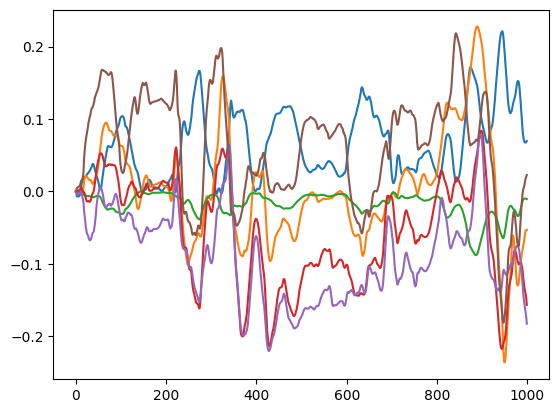

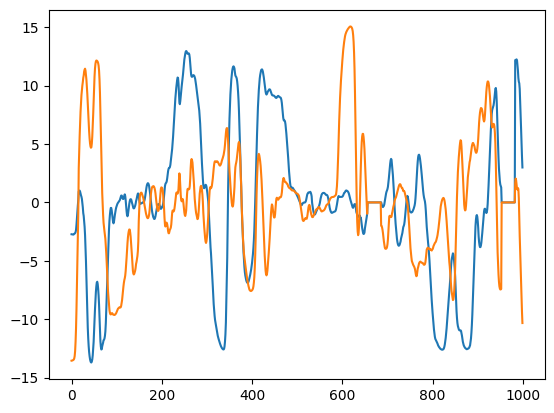

In [6]:
import os
print(os.getcwd())
score = dataProcessor.reg.score(dataProcessor.featureTestData,dataProcessor.outputTestData)
print(score)

plt.plot(dataProcessor.featureTestData[0:1000,:])
plt.show()
plt.plot(dataProcessor.outputTestData[0:1000,:])
plt.show()
predictions = dataProcessor.reg.predict(dataProcessor.featureTestData[3:])
truths = dataProcessor.outputTestData

dataProcessor.createNormaliserForClosedLoop()
dataProcessor.reg.DOFmeans = dataProcessor.featureTestDataDOFMeans


with open(savePath, 'wb') as file:
        pickle.dump(dataProcessor.reg, file)


In [7]:
dataProcessor.reg.coef_.shape

(2, 6)

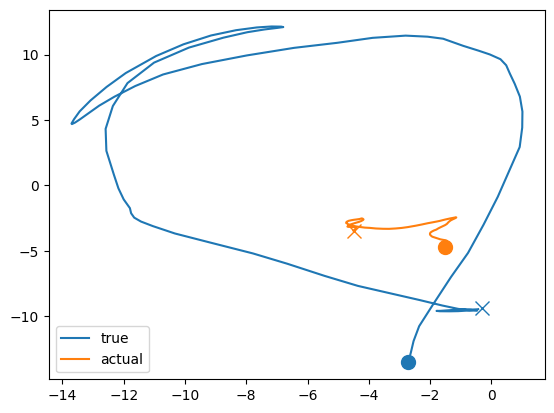

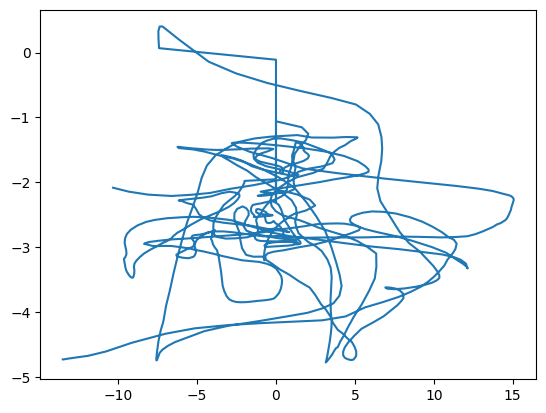

In [8]:
# predictions[:,0] = (predictions[:,0] - 6)/3
# predictions[:,1] = (predictions[:,1] - 1)/2
# truths[:,0] = (truths[:,0] +2) / 4
# truths[:,1] = (truths[:,1] + 2) / 10
truths[:,0] = +truths[:,0]
plotComparison(truths,predictions,0,100)
#print(truths.shape,predictions.shape)


plt.plot(truths[3:1000,1],predictions[:997,1])

In [9]:
# THIS SECTION SHOWS THAT BY HAVING THE CONTROL RIGID BODY INFORMATION, ONE CAN
# PERFECTLY DECODE THE CURSOR VELOCITY AND POSITION

print(dataProcessor.testDataGameEngine.pcaleftRight.components_)
print(dataProcessor.testDataGameEngine.pcaUpDown.components_)
# retrieve cal matrix
calMatrix = dataProcessor.testDataGameEngine.calibrationMatrix
controlData = dataProcessor.testDataGameEngine.controlRigidBodyDatastore

# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData[:,:3].transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.testFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
controlData_calibrated.shape # shape 1877 x 3

# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

# now cal velocities from control Data
calcVelocitiesX = dataProcessor.testDataGameEngine.pcaleftRight.transform(controlData_calibrated)

calcVelocitiesY = dataProcessor.testDataGameEngine.pcaUpDown.transform(controlData_calibrated)

predVelX = np.zeros(calcVelocitiesX.shape)
predVelY = np.zeros(calcVelocitiesX.shape)
print(len(calcVelocitiesX))
displacementX = 1270 // 2
displacementY = 740 // 2

cursor = dataProcessor.testDataGameEngine.cursor

dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
estDists = np.zeros(dists.shape)
for i in range(0,len(velocityData[:,0])-1):
    if cursor.xInvert:
        normalised_x_val = 1 -  (  calcVelocitiesX[i] - cursor.userMinXValue) / cursor.xRange
    else:
        normalised_x_val =   (calcVelocitiesX[i] - cursor.userMinXValue) / cursor.xRange
    if cursor.yInvert:
        normalised_y_Val = ( calcVelocitiesY[i] - cursor.userMinYValue) / cursor.yRange
    else:  
        normalised_y_Val = 1 - (calcVelocitiesY[i] - cursor.userMinYValue) / cursor.yRange


    x_target = normalised_x_val * 1270
    y_target = normalised_y_Val * 740

    useActualDist = False
    if useActualDist:
        distanceX = x_target - dists[i,0]
        distanceY = y_target - dists[i,1]
    else:
        distanceX = x_target - displacementX
        distanceY = y_target - displacementY

    predVelX[i] = distanceX * 0.06
    predVelY[i] = distanceY * 0.06

    estDists[i,0] = displacementX
    estDists[i,1] = displacementY

    displacementX = displacementX + predVelX[i] * 0.92
    displacementY = displacementY + predVelY[i] * 0.92

predVels = np.zeros(velocityData.shape)
predVels[:,0] = predVelX.reshape(-1)
predVels[:,1] = predVelY.reshape(-1)



print(dists.shape)




plotComparison(dists,estDists,plotFrom=500,plotTo=800,label =' displacement')



[[ 0.2982208  -0.9544513   0.00933081]]
[[-0.31345877 -0.12822523 -0.94090482]]
2785


ValueError: could not broadcast input array from shape (2785,) into shape (2783,)

In [ ]:


plotComparison(velocityData,predVels,plotFrom=300,plotTo=500,label = ' vel')

In [ ]:
# cursor.xInvert
# cursor.yInvert
# pca_lr = dataProcessor.testDataGameEngine.pcaleftRight
# pca_ud = dataProcessor.testDataGameEngine.pcaUpDown
# pca_y = pca_ud.transform(np.asarray([-1.32410509, -1.74628657,  0.72892797]).reshape(1,-1))
# normalised_y_Val = 1 - (pca_y - cursor.userMinYValue) / cursor.yRange
# y_target = normalised_y_Val * 740
# distanceY = y_target - cursorPos # need to find this
# velY = distanceY * 0.06
# velY
# we need an estimat eof the cursor pos to find this

In [ ]:
from sklearn.metrics import r2_score 
class StateModel():
    def __init__(self,F,G,H,X0):
        self.F = F
        self.G = G
        self.H = H
        self.X0 = X0
    
    def findZ_X_noNoise(self,u,addOffset = False):
        if addOffset:
            u_ = np.zeros((u.shape[0],u.shape[1]+1))
            u_[:,:-1] = u
            u_[:,-1]  = np.ones(u.shape[0])
            u = u_
        iterations = len(u[:,0])
        self.Z = np.zeros((iterations,4)) # hold velocities here
        self.X = np.zeros((iterations,4))
        # start
        x_curr = self.X0
        for idx in range(0,iterations-1):
            #print(self.F.shape,x_curr.shape,self.G.shape,u[idx].shape)
            x_next = np.matmul(self.F,x_curr.reshape(4,1)) + np.matmul(self.G,u[idx].reshape(7,1)) #+ np.random.random(size = X0.shape).reshape(4,1) * 3
            #print(x_next.shape)
            z_next = np.matmul(self.H,x_next.reshape(4,1))
            self.Z[idx,:] = z_next.reshape(4)
            self.X[idx,:] = x_next.reshape(4)
            x_curr = x_next

    def findOptimalG(self,U, addOffset = False):
        """
        Uses MLE of G in training data
        u needs to have its mean pca subtracted
        """
        if addOffset:
            U_ = np.zeros((U.shape[0],U.shape[1]+1))
            U_[:,:-1] = U
            U_[:,-1]  = np.ones(U.shape[0])
            U = U_
        X = self.X[1:,:].T # ignore first sample as need a delay
        iterations = X.shape[0] - 1
        U = U[1:,:].T # ignore first sample for same reason
        noInputParams = U.shape[1]
        X_delay =  self.X[0:-1,:].T # ignore last sample as this is the delay
        F = self.F
        G_est = np.zeros((4,noInputParams))
        print(X_delay.shape,U.shape,X.shape,F.shape)
        G_est = np.matmul( (np.matmul(F,np.matmul(X_delay,U.T)) - np.matmul(X,U.T) )  ,  np.linalg.inv(np.matmul(U,U.T)+ 0.000001 * np.identity(7) )    )
        self.G_opt = - G_est
# U_tot = np.zeros((7,7))
# for i in range(iterations):
#     U_tot += np.matmul(U[:,0].reshape(-1,1),U[:,0].reshape(-1,1).T)
        

            


    



In [ ]:
# Define F,G,H based on knowledge of model to see if model works first, initially assume no noise
F = np.mat([[1,0,0.92,0],[0,1,0,0.92],[-0.06,0,-0.06,0],[0,-0.06,0,0]])

comp_x = dataProcessor.testDataGameEngine.pcaleftRight.components_
comp_y = dataProcessor.testDataGameEngine.pcaUpDown.components_
G = np.zeros((4,7))


G[3,:3] = comp_y

H = np.mat([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(H.shape)

offset_x = cursor.userMinXValue/cursor.xRange 
grad_x = 1/cursor.xRange

G[2,6] = -offset_x
G[2,:3] = comp_x
G[2,:3] = G[2,:3] * grad_x
G[2,:] *= 1270 * 0.06

offset_y = cursor.userMinYValue/cursor.yRange
grad_y = 1/ cursor.yRange

G[3,6] = -offset_y
G[3,:3] = G[3,:3] * grad_y
G[3,:] *= 740 * 0.06

X0 = np.asarray([1270//2,740//2,0,0]).transpose()
u = np.zeros((1880,7))
u[:,:3] = controlData_calibrated - dataProcessor.testDataGameEngine.pcaleftRight.mean_
u[:,6] = np.ones(1880)


mdl = StateModel(F,G,H,X0)
mdl.findZ_X_noNoise(u)

dists_ = dists.copy()
dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl.Z,plotFrom = 1000,plotTo = 1100)

velocityData_ = velocityData.copy()
velocityData_[:,1] = - velocityData[:,1] 

plotComparison(velocityData_,mdl.Z[:,2:],plotFrom = 1000,plotTo = 1100)


mdl.findOptimalG(u)
dists_diff = np.diff(dists,axis=0)
predDists_diff = np.diff(mdl.Z[:,0:2],axis = 0)

plotComparison(dists_diff,predDists_diff,plotFrom=1000,plotTo=1100)

R_square = r2_score(dists_diff, predDists_diff) 
print('Coefficient of Determination', R_square) 

In [ ]:
mdl.G

In [ ]:
testG = mdl.G_opt

In [ ]:
# Now we will refit the data to the dynamical system
# First train the model on the training data to find an estimate for G
# Define F,G,H based on knowledge of model to see if model works first, initially assume no noise

F = np.mat([[1,0,0.92,0],[0,1,0,0.92],[-0.06,0,-0.06,0],[0,-0.06,0,0]])

comp_x = dataProcessor.trainingDataGameEngine.pcaleftRight.components_
comp_y = dataProcessor.trainingDataGameEngine.pcaUpDown.components_

if dataProcessor.trainingDataGameEngine.xInvert:
    comp_x = - comp_x
if dataProcessor.trainingDataGameEngine.yInvert:
    comp_y = - comp_y
cursor = dataProcessor.trainingDataGameEngine.cursor
G = np.zeros((4,7)) # we will have 7 inputs # correspond to the rigid bodies of the hand and one corresponds to the offset


G[3,:3] = comp_y

H = np.mat([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(H.shape)

# Define G for training data - this is used to simulate the states developing, in actual
# fact the states should be found in the old system
offset_x = cursor.userMinXValue/cursor.xRange 
grad_x = 1/cursor.xRange

G[2,6] = -offset_x
G[2,:3] = comp_x
G[2,:3] = G[2,:3] * grad_x
G[2,:] *= 1270 * 0.06

offset_y = cursor.userMinYValue/cursor.yRange
grad_y = 1/ cursor.yRange

G[3,6] = -offset_y
G[3,:3] = G[3,:3] * grad_y
G[3,:] *= 740 * 0.06

#

# define X0

X0 = np.asarray([1270//2,740//2,0,0]).transpose()

# Retrieve the control inputs

# retrieve cal matrix
calMatrix_ = dataProcessor.trainingDataGameEngine.calibrationMatrix
calMatrix = np.zeros((6,6))
calMatrix[0:3,0:3] = calMatrix_
calMatrix[3:6,3:6] = calMatrix_
controlData = dataProcessor.trainingDataGameEngine.controlRigidBodyDatastore
# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData.transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.trainingFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
print(controlData_calibrated.shape) # shape ... x 3
noRecordings = controlData_calibrated.shape[0]
u = np.zeros((noRecordings,7))
u[:,:3] = controlData_calibrated[:,:3] - dataProcessor.trainingDataGameEngine.pcaleftRight.mean_
u[:,6] = np.ones(noRecordings)


mdl = StateModel(F,G,H,X0)
mdl.findZ_X_noNoise(u) # simulating calculating datapoints
dists = dataProcessor.trainingDataGameEngine.cursorPositionWriteDatastore[1:,:]
dists_ = dists.copy()
dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
velocityData_[:,1] = - velocityData[:,1] 

plotComparison(velocityData_,mdl.Z[:,2:],plotFrom = 1000,plotTo = 1100)


mdl.findOptimalG(u)
G_opt = mdl.G_opt
G_opt[0:2,:] = np.zeros((2,7))
# NOW TEST ON TEST SET USING OPTIMAL G
testmdl = StateModel(F,mdl.G_opt,H,X0)

# Retrieve the control inputs

# retrieve cal matrix
calMatrix_ = dataProcessor.testDataGameEngine.calibrationMatrix
calMatrix = np.zeros((6,6))
calMatrix[0:3,0:3] = calMatrix_
calMatrix[3:6,3:6] = calMatrix_
controlData = dataProcessor.testDataGameEngine.controlRigidBodyDatastore
# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData.transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.testFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
print(controlData_calibrated.shape) # shape ... x 3
noRecordings = controlData_calibrated.shape[0]
u = np.zeros((noRecordings,7))
u[:,:3] = controlData_calibrated[:,:3] - dataProcessor.testDataGameEngine.pcaleftRight.mean_
u[:,6] = np.ones(noRecordings)
# run dynamical model
testmdl.findZ_X_noNoise(u)
print('TEST SET')
dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
dists_ = dists.copy()
dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl.Z,plotFrom = 900,plotTo = 1000)


# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
velocityData_[:,1] = - velocityData[:,1] 

plotComparison(velocityData_,mdl.Z[:,2:],plotFrom = 900,plotTo = 1000)

In [ ]:
comp_x_test = dataProcessor.testDataGameEngine.pcaleftRight.components_
comp_y_test = dataProcessor.testDataGameEngine.pcaUpDown.components_
comp_x_train = dataProcessor.trainingDataGameEngine.pcaleftRight.components_
comp_y_train = dataProcessor.trainingDataGameEngine.pcaUpDown.components_
print(comp_x_test)
print(comp_x_train)
print(comp_y_test)
print(comp_y_train)
print(testmdl.G)
testG

In [ ]:
# Now let's try to fit data without explicitly teaching it about g still only for tight hand
F = np.mat([[1,0,0.92,0],[0,1,0,0.92],[-0.06,0,-0.06,0],[0,-0.06,0,0]])

H = np.mat([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(H.shape)

mdl_2 = StateModel(F,G = None, H = H,X0 = X0)


# Retrieve control Input
# retrieve cal matrix
calMatrix_ = dataProcessor.trainingDataGameEngine.calibrationMatrix
calMatrix = np.zeros((6,6))
calMatrix[0:3,0:3] = calMatrix_
calMatrix[3:6,3:6] = calMatrix_
controlData = dataProcessor.trainingDataGameEngine.controlRigidBodyDatastore
# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData.transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.trainingFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
print(controlData_calibrated.shape) # shape ... x 3
noRecordings = controlData_calibrated.shape[0]
u = np.zeros((noRecordings,7))
u[:,:3] = controlData_calibrated[:,:3] - dataProcessor.trainingDataGameEngine.pcaleftRight.mean_
u[:,6] = np.ones(noRecordings)



velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[1:]
dists = dataProcessor.trainingDataGameEngine.cursorPositionWriteDatastore[1:,:]
X = np.zeros((dists.shape[0],4))
X[:,0:2] = dists
X[:,2:4] = velocityData
mdl_2.X = X
mdl_2.findOptimalG(u)
mdl_2.G = mdl_2.G_opt
mdl_2.findZ_X_noNoise(u)

dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)


# NOW test on TEST DATA

print("TEST")

# Retrieve control Input
# retrieve cal matrix
calMatrix_ = dataProcessor.testDataGameEngine.calibrationMatrix
calMatrix = np.zeros((6,6))
calMatrix[0:3,0:3] = calMatrix_
calMatrix[3:6,3:6] = calMatrix_
controlData = dataProcessor.testDataGameEngine.controlRigidBodyDatastore
# calibrated
controlData_calibrated = np.matmul(calMatrix,controlData.transpose()).transpose()

# delete calibration data
calIdx = dataProcessor.testFinalCalibrationIdx
controlData_calibrated = controlData_calibrated[calIdx+1:]
print(controlData_calibrated.shape) # shape ... x 3
noRecordings = controlData_calibrated.shape[0]
u = np.zeros((noRecordings,7))
u[:,:3] = controlData_calibrated[:,:3] - dataProcessor.testDataGameEngine.pcaleftRight.mean_
u[:,6] = np.ones(noRecordings)

mdl_2.findZ_X_noNoise(u)


dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)




In [ ]:
# Now let's try to fit data using ProcessData class for right hand 

dataProcessor = ProcessData('../GameSaves/Ashwin_09_01__17_05_10mins_updated2.pkl','../GameSaves/Ashwin_09_01__17_20_90s_updated.pkl')
dataProcessor.retrieveTrainingFeatureData(rigidBodyGroup= "B")
dataProcessor.retrieveTestFeatureData(rigidBodyGroup="B")


# Normalise training and test data
dataProcessor.retrieveTestOutputs()
dataProcessor.retrieveTrainingOutputs()

dataProcessor.normaliseDatasets(byVariance=False,delCalibrationData=True)
print(dataProcessor.outputTrainingData.shape,dataProcessor.featureTrainingData.shape)
print(dataProcessor.outputTestData.shape,dataProcessor.featureTestData.shape)


F = np.mat([[1,0,0.92,0],[0,1,0,0.92],[-0.06,0,-0.06,0],[0,-0.06,0,0]])

H = np.mat([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(H.shape)

mdl_2 = StateModel(F,G = None, H = H,X0 = X0)






velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[2:]
dists = dataProcessor.trainingDataGameEngine.cursorPositionWriteDatastore[2:,:]
X = np.zeros((dists.shape[0],4))
X[:,0:2] = dists
X[:,2:4] = velocityData
mdl_2.X = X
mdl_2.findOptimalG(dataProcessor.featureTrainingData,addOffset = True)
mdl_2.G = mdl_2.G_opt
mdl_2.findZ_X_noNoise(dataProcessor.featureTrainingData,addOffset = True)

dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)


# NOW test on TEST DATA

print("TEST")


mdl_2.findZ_X_noNoise(dataProcessor.featureTestData,addOffset = True)


dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)




In [ ]:
# Now let's try to fit data using ProcessData class for left hand

dataProcessor = ProcessData('../GameSaves/Ashwin_09_01__17_05_10mins_updated2.pkl','../GameSaves/Ashwin_09_01__17_20_90s_updated.pkl')
dataProcessor.retrieveTrainingFeatureData(rigidBodyGroup= "B")
dataProcessor.retrieveTestFeatureData(rigidBodyGroup="B")


# Normalise training and test data
dataProcessor.retrieveTestOutputs()
dataProcessor.retrieveTrainingOutputs()

dataProcessor.normaliseDatasets(byVariance=False,delCalibrationData=True)
print(dataProcessor.outputTrainingData.shape,dataProcessor.featureTrainingData.shape)
print(dataProcessor.outputTestData.shape,dataProcessor.featureTestData.shape)


F = np.mat([[1,0,0.92,0],[0,1,0,0.92],[-0.06,0,-0.06,0],[0,-0.06,0,0]])

H = np.mat([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(H.shape)

mdl_2 = StateModel(F,G = None, H = H,X0 = X0)






velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[2:]
dists = dataProcessor.trainingDataGameEngine.cursorPositionWriteDatastore[2:,:]
X = np.zeros((dists.shape[0],4))
X[:,0:2] = dists
X[:,2:4] = velocityData
mdl_2.X = X
mdl_2.findOptimalG(dataProcessor.featureTrainingData,addOffset = True)
mdl_2.G = mdl_2.G_opt
mdl_2.findZ_X_noNoise(dataProcessor.featureTrainingData,addOffset = True)

dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.trainingDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)


# NOW test on TEST DATA

print("TEST")


mdl_2.findZ_X_noNoise(dataProcessor.featureTestData,addOffset = True)


dists = dataProcessor.testDataGameEngine.cursorPositionWriteDatastore[1:,:]
dists_ = dists.copy()
#dists_[:,1] = - dists[:,1] + 700
plotComparison(dists_,mdl_2.Z,plotFrom = 1000,plotTo = 1100)


# fetch list of velocities
velocityData = dataProcessor.testDataGameEngine.cursorVelocityWriteDatastore[1:]
velocityData.shape # shape 1877 x 2

velocityData_ = velocityData.copy()
#velocityData_[:,1] =  velocityData[:,1] 

plotComparison(velocityData_,mdl_2.Z[:,2:],plotFrom = 1000,plotTo = 1100)




In [ ]:
# fit a linear model in general
from sklearn.linear_model import LinearRegression
print(dataProcessor.featureTestData[2:].shape)
# dataProcessor.featureTestData = dataProcessor.featureTestData[2:]
print(dataProcessor.featureTrainingData[4:].shape)
# dataProcessor.featureTrainingData=dataProcessor.featureTrainingData
print(dataProcessor.outputTrainingData.shape)
print(dataProcessor.outputTestData.shape)

reg = LinearRegression()
reg.fit(dataProcessor.featureTrainingData,dataProcessor.outputTrainingData)
reg.score(dataProcessor.featureTestData,dataProcessor.outputTestData)
preds = reg.predict(dataProcessor.featureTestData)
plotComparison(dataProcessor.outputTestData,preds,plotFrom = 0, plotTo = 200)

# this performs badly 